In [196]:
from darts.utils.statistics import stationarity_tests, check_seasonality
from darts.timeseries import TimeSeries
from statsmodels.tsa.seasonal import STL
import prophet as Prophet
import pandas as pd
import numpy as np
from scipy.stats import median_abs_deviation

In [197]:
class TimeSeriesStats:

    def __init__(self, time_series):
        """Initialize the time series

        Args:
            time_series (pandas Series): valid time series sequence without dt or ds
        """
        self.ts = TimeSeries.from_series(time_series)

    def check_stationarity(self):
        """Checks if the time series data is stationary or not

        Returns:
            stationarity (bool): True - stationary, False - non-stationary
        """
        stationary = stationarity_tests(self.ts, p_value_threshold_adfuller=0.05, p_value_threshold_kpss=0.05)
        return stationary

    def check_seasonality_period(self):
        """Checks if the non-stationary time series data has seasonality or not

        Returns:
    
            seasonality (bool): True - Seasonal, False - not seasonal
            seasonal_period (int): If True, value is the period of seasonality
            
        """
        seasonality, seasoanal_period = check_seasonality(self.ts)
        return seasonality, seasoanal_period

    def get_residuals(self, ts, seasonality_results):
        """Decomposes Residuals from a time series data after performing STL decomposition

        Args:
            ts (pandas series): Time series to decompose
            seasonality_results (tuple): A tuple of seasonality(Boolean) and period of seasonality(int)
        returns:
            resid (pandas series): residuals after decomposition
        """
        seasonality, period = seasonality_results
        if seasonality:
            stl = STL(ts[ts.columns[1]], period = period)
        else:
            stl = STL(ts.columns[1], period = None)
        result = stl.fit()
        return result.resid
        
        


In [198]:
from abc import ABC, abstractmethod 

class AnomalyDetector(ABC):

    @abstractmethod
    def fit():
        pass

    @abstractmethod
    def predict():
        pass
        
    


In [223]:
class ProphetForAnomalyDetector(AnomalyDetector):

    def __init__(self, time_series):
        """Initialize the time series

        Args:
            time_series (pandas Series): valid time series sequence without dt or ds
        """
        self.ts = time_series.copy()
        if len(self.ts.columns) != 2:
            raise ValueError("Need two columns, in the dataframe, one with date and another with kpi")
        self.kpi_name = self.ts.columns[1]
        self.date_name = self.ts.columns[0]
        self.model = None

    def transform(self):
        """Renames columns to ds & y, and transforms the date_time field to pandas date series columns as requested by prophet

        Args:
            None
        """
        if 'ds' not in self.ts.columns:
            self.ts = self.ts.rename(columns={self.date_name: "ds"})
        if 'y' not in self.ts.columns:
            self.ts = self.ts.rename(columns = {self.kpi_name: "y"})
        if not pd.api.types.is_datetime64_any_dtype(self.ts['ds']):
            self.ts['ds'] =  pd.to_datetime(self.ts['ds'], format='%Y-%m-%d', errors='raise')
        
    def fit(self, interval_width = 0.99, changepoint_range = 1):
        """Fits the model to the time series data

        Args:
            interval_width (float): a float number between 0 to 1, defines the uncertainity or confidence interval
            changepoint_range (float): a float number between 0 to 1, denotes the percentage of data from start to be used for changepoint detection

        Returns:
            self.model (Prophet): Trained model for deep analysis outside the class (by default predict method takes self.model)
        """
        self.model = Prophet.Prophet(changepoint_range = changepoint_range, interval_width = interval_width)
        self.model = self.model.fit(self.ts)
        return self.model
               
    def predict(self):
        """Predicts the confidence interval range and detects anomalies in a dataset

        Args:
            None

        Returns:
            Anomalies (pandas dataframe): the initially sent time series dataframe with additionally added anomaly series for each record 
        """
        if self.model:
            forecast = self.model.predict(self.ts)
            forecast['fact'] = self.ts['y'].reset_index(drop = True)
            forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
            forecasted['anomaly'] = 0
            forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
            forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
            anomalies = forecasted[['ds', 'fact', 'anomaly']].rename(columns={'ds':self.date_name, 'fact':self.kpi_name})
            return anomalies
        else:
            raise ValueError("self.model is None, Check if model fit is success")



In [200]:
class IQRForAnomalyDetector(AnomalyDetector):
    

    def __init__(self, time_series):
        """Initialize the time series

        Args:
            time_series (pandas Series): valid time series sequence without dt or ds
        """
        self.ts = time_series.copy()
        if len(self.ts.columns) != 2:
            raise ValueError("Need two columns, in the dataframe, one with date and another with kpi")
        self.kpi_name = self.ts.columns[1]
        self.date_name = self.ts.columns[0]
        self.stationarity = False
        self.limits = None
        self.resid = None

    def get_limits(self, time_series, threshold):
        """Calculates lower and upper limit for Anomaly detection using IQR method

        Args:
            time_series (pandas series): 
            threshold (float): threshold multiplier with IQR, defaults to 1.5

        Returns:
            low_lim (float): lower limit for the IQR
            up_lim (float): upper limit for the IQR
        """
        
        Q1 = time_series[self.kpi_name].quantile(0.25)
        Q3 = time_series[self.kpi_name].quantile(0.75)
        IQR = Q3 - Q1
        low_lim = Q1 - threshold * IQR
        up_lim = Q3 + threshold * IQR
        return low_lim, up_lim
        
    def fit(self, threshold = 1.5):
        """Fits the time series data, checks stationarity and computes limits for IQR as required

        Args:
            threshold: threshold multiplier with IQR, defaults to 1.5

        Returns:
            self.limits (tuple): (low_lim, up_lim) for IQR
        """
        darts_time_series = TimeSeriesStats(self.ts[self.kpi_name])
        stationarity = darts_time_series.check_stationarity()
        if stationarity:
            low_lim, up_lim = self.get_limits(self.ts, threshold)
        else:
            seasonality_results = darts_time_series.check_seasonality_period()
            resid = darts_time_series.get_residuals(self.ts, seasonality_results)
            resid_df = pd.DataFrame({self.kpi_name: resid})
            resid_df.index = self.ts.index
            self.resid = resid_df
            self.limits = self.get_limits(self.resid ,threshold)
        return self.limits

    
    def predict(self):
        """Predicts the anomalies based on the lower limit and upper limit for IQR range from time series or residuals

        Args:
            None

        Returns:
            Anomalies (pandas dataframe): the initially sent time series dataframe with additionally added anomaly series for each record
        """
        self.ts['anomaly'] = 0
        if self.limits is None:
            raise ValueError("Upper and lower limits for IQR is not decided yet")
        if self.resid is not None:
            self.resid['anomaly'] = 0
            self.resid.loc[self.resid[self.kpi_name].lt(self.limits[0]), 'anomaly'] = -1
            self.resid.loc[self.resid[self.kpi_name].gt(self.limits[1]), 'anomaly'] = 1
            self.ts['anomaly'] = self.resid['anomaly']
        else:
            self.ts.loc[self.ts[self.kpi_name].lt(self.limits[0]), 'anomaly'] = -1
            self.ts.loc[self.ts[self.kpi_name].gt(self.limits[1]), 'anomaly'] = 1
        anomalies = self.ts
        return anomalies


class RobustZForAnomalyDetector:

    def __init__(self, time_series):
        """Initialize the time series

        Args:
            time_series (pandas Series): valid time series sequence without dt or ds
        """
        self.ts = time_series.copy()
        if len(self.ts.columns) != 2:
            raise ValueError("Need two columns, in the dataframe, one with date and another with kpi")
        self.kpi_name = self.ts.columns[1]
        self.date_name = self.ts.columns[0]
        self.stationarity = False
        self.z_thresh = None
        self.mad = None
        self.median = None

    def robust_z_score(self, time_series_value):
        """Calculate robust z score based on the formula

        Args:
            time_series_value (float): value from a series for which z-score to be calculated

        Returns:
            z_score (float): score based on the formula
        """
        z_score = 0.6745 * (time_series_value - self.median)/self.mad
        return z_score
    
    def fit(self, threshold = 3.5):
        """Fits the time series data and calculates the z-score

        Args:
            threshold (float): score threshold for anomaly, defaults to 3.5

        Returns:
            time_series_z_score (pandas series): the z-score calculated for all rows
        """
        self.threshold = threshold
        self.mad = median_abs_deviation(self.ts[self.kpi_name])
        self.median = np.median(self.ts[self.kpi_name])
        if self.mad == 0:
            self.mad = 0.1
        self.ts['z_score'] = self.ts[self.kpi_name].apply(self.robust_z_score)
        return self.ts['z_score']
        

    def predict(self):
        """Predicts based on the threshold value for z-score, if the record is anomaly or not

        Args:
            None
        """
        self.ts['anomaly'] = 0
        self.ts.loc[self.ts['z_score']>=self.threshold, 'anomaly'] = 1
        self.ts.loc[self.ts['z_score']<=-self.threshold, 'anomaly'] = -1
        anomalies = self.ts[[self.date_name, self.kpi_name, 'anomaly']]
        return anomalies
        
        




In [201]:
import pandas as pd
cat_fish = pd.read_csv('catfish.csv')
cat_fish.head()

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239


In [202]:
pad = ProphetForAnomalyDetector(cat_fish)

In [203]:
pad.transform()

In [204]:
pad.fit()

14:39:20 - cmdstanpy - INFO - Chain [1] start processing
14:39:20 - cmdstanpy - INFO - Chain [1] done processing


In [205]:
anomalies = pad.predict()

Date Total


In [206]:
anomalies

,Date,Total,anomaly
0,1986-01-01,9034,0
1,1986-02-01,9596,0
2,1986-03-01,10558,0
3,1986-04-01,9002,0
4,1986-05-01,9239,0
...,...,...,...
319,2012-08-01,14442,0
320,2012-09-01,13422,0
321,2012-10-01,13795,0
322,2012-11-01,13352,0


In [207]:
anomalies[anomalies['anomaly']==1]

,Date,Total,anomaly
289,2010-02-01,22617,1
296,2010-09-01,20280,1


In [208]:
iad = IQRForAnomalyDetector(cat_fish)
iad.fit()
iad_anomaly = iad.predict()

(-2102.2167914575443, 2137.207960229119)
           Total  anomaly
time                     
0     287.555972        0
1     449.308706        0
2     -33.113408        0
3    -714.739555        0
4    -902.370412        0


/Users/aswin/miniconda3/envs/mlenv/lib/python3.9/site-packages/darts/utils/statistics.py:467: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


In [209]:
zad = RobustZForAnomalyDetector(cat_fish)
zad.fit()
zad_anomaly = zad.predict()

In [210]:
total = anomalies['anomaly'] + iad_anomaly['anomaly'] + zad_anomaly['anomaly']

In [211]:
total[total==2]

289    2
Name: anomaly, dtype: int64

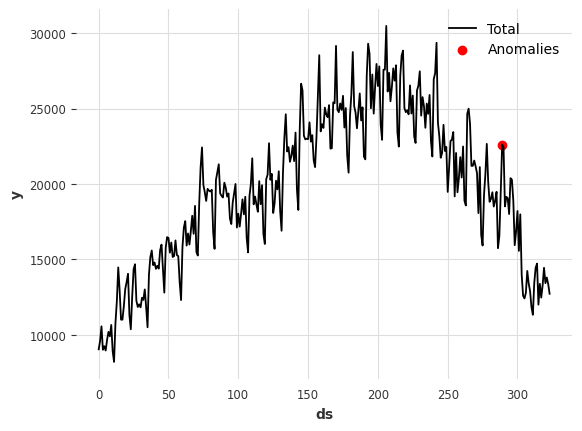

In [212]:
import matplotlib.pyplot as plt
plt.plot(cat_fish.index, cat_fish['Total'], label='Total')
plt.scatter(total[total==2].index, cat_fish.loc[total[total==2].index, 'Total'], color='red', label='Anomalies')
plt.xlabel('ds')
plt.ylabel('y')
plt.legend()
plt.show()

In [215]:
import datetime
sales_data = pd.read_csv('sales_weekly.csv')
sales_data.set_index('Product_Code', inplace=True)
sales_data_t = sales_data.T
sales_final_data = sales_data_t.iloc[:52]
df_sales_anomaly = pd.DataFrame(sales_final_data['P1'], columns=['P1'])
df_sales_anomaly.index = df_sales_anomaly.index.map(lambda x: '2023 '+x + ' 1')
df_sales_anomaly.index = df_sales_anomaly.index.map(lambda x: datetime.datetime.strptime(x, "%Y W%W %w"))
df_sales_anomaly = df_sales_anomaly.reset_index().rename(columns={"index": "Date", "P1":"Sales_1"})

In [220]:
df_sales_anomaly.head()

,Date,Sales_1
0,2022-12-26,11.0
1,2023-01-02,12.0
2,2023-01-09,10.0
3,2023-01-16,8.0
4,2023-01-23,13.0


15:00:14 - cmdstanpy - INFO - Chain [1] start processing
15:00:14 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'y'], dtype='object') Sales_1 Date
Date Sales_1
(-4.6019461764494345, 4.6206112300817175)
       Sales_1  anomaly
time                   
0    -1.127649        0
1     1.941035        0
2    -0.199047        0
3    -2.330486        0
4     2.559922        0


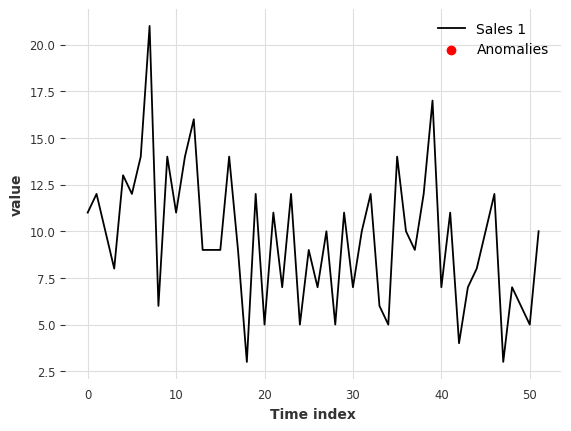

In [236]:
df = df_sales_anomaly

pad = ProphetForAnomalyDetector(df)
pad.transform()
pad.fit()
pad_anomaly = pad.predict()

iad = IQRForAnomalyDetector(df)
iad.fit()
iad_anomaly = iad.predict()

zad = RobustZForAnomalyDetector(df)
zad.fit()
zad_anomaly = zad.predict()

total = pad_anomaly['anomaly'] + iad_anomaly['anomaly'] + zad_anomaly['anomaly']


plt.plot(df.index, df['Sales_1'], label='Sales 1')
plt.scatter(total[total==2].index, df.loc[total[total==2].index, 'Sales_1'], color='red', label='Anomalies')
plt.xlabel('Time index')
plt.ylabel('value')
plt.legend()
plt.show()